In [1]:
import os

import joblib
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

print(os.listdir("../data"))
import warnings

warnings.filterwarnings('ignore')

['IMDB Dataset.csv']


In [2]:
models_path = "../models/"
X_train, X_test, y_train, y_test = joblib.load(models_path + "split_data.pkl")
tokenizer = joblib.load(models_path + "artifacts/tokenizer.pkl")

In [3]:
tokenizer.fit_on_texts(X_train)

In [4]:
# Text → sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [5]:
# Padding
MAX_LEN = 200

X_train_pad = pad_sequences(
    X_train_seq,
    maxlen=MAX_LEN,
    padding="post",
    truncating="post"
)

X_test_pad = pad_sequences(
    X_test_seq,
    maxlen=MAX_LEN,
    padding="post",
    truncating="post"
)

In [6]:
y_train_num = y_train.map({'positive': 1, 'negative': 0})
y_test_num = y_test.map({'positive': 1, 'negative': 0})

In [7]:
lstm_model = Sequential([
    Embedding(
        input_dim=30000,
        output_dim=128,
        input_length=MAX_LEN
    ),
    Dropout(0.3),

    LSTM(
        units=128,
        return_sequences=False
    ),
    Dropout(0.3),

    Dense(64, activation="relu"),
    Dropout(0.5),

    Dense(1, activation="sigmoid")
])

lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
lstm_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [9]:
# Show progress bar
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.pbar = tqdm(total=self.epochs, desc='Training Progress')

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        self.pbar.set_postfix(val_loss=logs.get('val_loss'), val_acc=logs.get('val_accuracy'))

    def on_train_end(self, logs=None):
        self.pbar.close()

In [10]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [11]:
lstm_history = lstm_model.fit(
    X_train_pad, y_train_num,
    validation_split=0.1,
    epochs=20,
    batch_size=128,
    callbacks=[early_stop, TQDMProgressBar()])


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5071 - loss: 0.6939

Training Progress:   5%|▌         | 1/20 [00:34<10:47, 34.10s/it, val_acc=0.539, val_loss=0.689]

282/282 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - accuracy: 0.5144 - loss: 0.6939 - val_accuracy: 0.5387 - val_loss: 0.6891
Epoch 2/20
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5650 - loss: 0.6739

Training Progress:  10%|█         | 2/20 [01:05<09:48, 32.68s/it, val_acc=0.582, val_loss=0.647]

282/282 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - accuracy: 0.5593 - loss: 0.6772 - val_accuracy: 0.5820 - val_loss: 0.6470
Epoch 3/20
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5827 - loss: 0.6478

Training Progress:  15%|█▌        | 3/20 [01:38<09:14, 32.59s/it, val_acc=0.652, val_loss=0.638]

282/282 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - accuracy: 0.6124 - loss: 0.6359 - val_accuracy: 0.6520 - val_loss: 0.6379
Epoch 4/20
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6960 - loss: 0.6013

Training Progress:  20%|██        | 4/20 [02:10<08:39, 32.49s/it, val_acc=0.589, val_loss=0.667]

282/282 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - accuracy: 0.7284 - loss: 0.5684 - val_accuracy: 0.5890 - val_loss: 0.6675
Epoch 5/20
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6549 - loss: 0.5760

Training Progress:  25%|██▌       | 5/20 [02:42<08:04, 32.28s/it, val_acc=0.834, val_loss=0.503]

282/282 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - accuracy: 0.6736 - loss: 0.5583 - val_accuracy: 0.8342 - val_loss: 0.5034
Epoch 6/20
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8535 - loss: 0.3864

Training Progress:  30%|███       | 6/20 [03:13<07:28, 32.00s/it, val_acc=0.854, val_loss=0.355]

282/282 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - accuracy: 0.8636 - loss: 0.3566 - val_accuracy: 0.8540 - val_loss: 0.3551
Epoch 7/20
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9166 - loss: 0.2415

Training Progress:  35%|███▌      | 7/20 [03:45<06:54, 31.88s/it, val_acc=0.858, val_loss=0.359]

282/282 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - accuracy: 0.9103 - loss: 0.2556 - val_accuracy: 0.8583 - val_loss: 0.3587
Epoch 8/20
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9371 - loss: 0.1862

Training Progress:  40%|████      | 8/20 [04:17<06:20, 31.73s/it, val_acc=0.866, val_loss=0.363]

282/282 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - accuracy: 0.9380 - loss: 0.1844 - val_accuracy: 0.8660 - val_loss: 0.3633
Epoch 9/20
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9615 - loss: 0.1273

Training Progress:  45%|████▌     | 9/20 [04:48<05:47, 31.58s/it, val_acc=0.863, val_loss=0.423]

282/282 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - accuracy: 0.9621 - loss: 0.1252 - val_accuracy: 0.8633 - val_loss: 0.4226


Training Progress:  45%|████▌     | 9/20 [04:48<05:52, 32.03s/it, val_acc=0.863, val_loss=0.423]


In [12]:
y_pred_prob = lstm_model.predict(X_test_pad)
y_val_pred = (y_pred_prob > 0.5).astype(int)
y_val_pred


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


array([[0],
       [1],
       [1],
       ...,
       [0],
       [1],
       [0]], shape=(10000, 1))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      5000
           1       0.88      0.83      0.85      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.86      0.86      0.85     10000



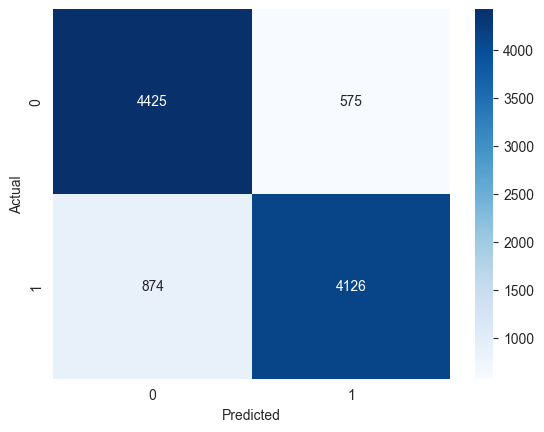

In [13]:
print(classification_report(y_test_num, y_val_pred))
cm = confusion_matrix(y_test_num, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- LSTM is worsen than CNN
- LSTM Deep Learning model is slightly overfitting than CNN

In [14]:
bilstm_model = Sequential([
    Embedding(
        input_dim=30000,
        output_dim=128,
        input_length=MAX_LEN
    ),
    Dropout(0.3),

    Bidirectional(
        LSTM(128, return_sequences=False)
    ),

    Dropout(0.3),

    Dense(64, activation="relu"),
    Dropout(0.5),

    Dense(1, activation="sigmoid")
])

bilstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
bilstm_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [16]:
bilstm_history = bilstm_model.fit(
    X_train_pad, y_train_num,
    validation_split=0.1,
    epochs=20,
    batch_size=128,
    callbacks=[early_stop, TQDMProgressBar()])


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6612 - loss: 0.5813

Training Progress:   5%|▌         | 1/20 [00:49<15:49, 49.98s/it, val_acc=0.872, val_loss=0.318]

282/282 ━━━━━━━━━━━━━━━━━━━━ 50s 172ms/step - accuracy: 0.7663 - loss: 0.4739 - val_accuracy: 0.8717 - val_loss: 0.3177
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9029 - loss: 0.2622

Training Progress:  10%|█         | 2/20 [01:41<15:18, 51.03s/it, val_acc=0.871, val_loss=0.323]

282/282 ━━━━━━━━━━━━━━━━━━━━ 52s 183ms/step - accuracy: 0.9039 - loss: 0.2562 - val_accuracy: 0.8708 - val_loss: 0.3226
Epoch 3/20
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9379 - loss: 0.1817

Training Progress:  15%|█▌        | 3/20 [02:37<15:02, 53.09s/it, val_acc=0.874, val_loss=0.34] 

282/282 ━━━━━━━━━━━━━━━━━━━━ 56s 197ms/step - accuracy: 0.9338 - loss: 0.1897 - val_accuracy: 0.8740 - val_loss: 0.3395
Epoch 4/20
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9549 - loss: 0.1332

Training Progress:  20%|██        | 4/20 [03:32<14:25, 54.07s/it, val_acc=0.873, val_loss=0.358]

282/282 ━━━━━━━━━━━━━━━━━━━━ 56s 197ms/step - accuracy: 0.9537 - loss: 0.1357 - val_accuracy: 0.8735 - val_loss: 0.3583


Training Progress:  20%|██        | 4/20 [03:32<14:11, 53.22s/it, val_acc=0.873, val_loss=0.358]


In [17]:
y_pred_prob = bilstm_model.predict(X_test_pad)
y_val_pred = (y_pred_prob > 0.5).astype(int)
y_val_pred


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


array([[1],
       [0],
       [1],
       ...,
       [0],
       [1],
       [0]], shape=(10000, 1))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      5000
           1       0.87      0.87      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



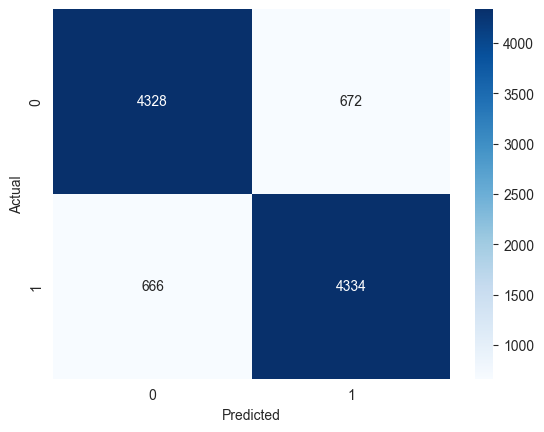

In [18]:
print(classification_report(y_test_num, y_val_pred))
cm = confusion_matrix(y_test_num, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- BiLSTM is slightly better than LSTM
- The accuracy is quite same but less overfitting than LSTM

# Day 8 - LSTM - BiLSTM

- CNN captures sentiment-relevant n-gram patterns more efficiently
- For short review sentiment tasks:
  - CNN is often the best practical choice
  - LSTM adds complexity without guaranteed gains
  - BiLSTM is better than LSTM